# Figure 5 – Functional validation of pathogenic TP53 variants identified with prime editing screening.
## Figure 5a
LFC of 29 pegRNAs selected for validation at Day 34 in the untreated condition. Variants with insufficient control counts (I195T, E285K, G325A, Y327Ter, A347D) represented with LFC = 0.

In [23]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

plt.rc('font', family='Helvetica')

In [4]:
#fishing out the pegRNAs used in the competition assay

p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


p_ids = ['peg_16602', 'peg_465', 'peg_2','peg_218', 'peg_31', 'peg_311', 'peg_178', 'peg_885', 'peg_683', 'peg_14531', 'peg_8247', 'peg_12022', 'peg_7449', 'peg_21875', 'peg_12868', 'peg_18555', 'peg_25828', 'peg_22204', 'peg_138', 'peg_6764', 'peg_4583', 'peg_1864', 'peg_9611', 'peg_27888', 'peg_26951','peg_26576', 'peg_21343', 'peg_4127', 'peg_55']

comp = p53_filtered[p53_filtered['peg_id'].isin(p_ids)].reset_index().drop(columns='index')


In [6]:
#loading in the merged replicates and merging with the competition assay
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck to extract LFC
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [26]:
#extracting information and merging with competition assay dataframe
d34_cp = []
d34_nut_cp = []
d34_lfc = []
d34_nut_lfc = []

counts_threshold = 10

for i in comp['peg_id']:
    #editing efficiency quantification
    d34 = cp_dict2['D34']
    d34 = d34[d34['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34_nut = cp_dict2['D34-NUT']
    d34_nut = d34_nut[d34_nut['Reads_aligned_all_amplicons'] >= counts_threshold]

    d34 = d34[d34['peg_id']==i]
    d34_nut = d34_nut[d34_nut['peg_id']==i]

    if len(d34)>0: #if sufficient sensor counts
        d34_cp.append(d34['corr_perc_backsub'].values[0])
    else:
        d34_cp.append(0)

    if len(d34_nut)>0: #if sufficient sensor counts
        d34_nut_cp.append(d34_nut['corr_perc_backsub'].values[0])
    else:
        d34_nut_cp.append(0)

    #LFC quantification
    d34_m = mageck_dict['D34']
    d34_nut_m = mageck_dict['D34-NUT']

    d34_m = d34_m[d34_m['peg_id']==i]
    d34_nut_m = d34_nut_m[d34_nut_m['peg_id']==i]

    if len(d34_m)>0: #if sufficient sensor counts
        d34_lfc.append(d34_m['LFC'].values[0])
    else:
        d34_lfc.append(0)

    if len(d34_nut_m)>0: #if sufficient sensor counts
        d34_nut_lfc.append(d34_nut_m['LFC'].values[0])
    else:
        d34_nut_lfc.append(0)


comp['Corr_perc_untreated'] = d34_cp
comp['Corr_perc_nutlin'] = d34_nut_cp
comp['LFC_untreated'] = d34_lfc
comp['LFC_nutlin'] = d34_nut_lfc

#and adding in some other info
mut = []
for idx, val in comp.iterrows():
    aa = val['HGVSp']
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


comp['Effect'] = mut


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_21844/3658813893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc[np.isnan(lfc)]=0


13

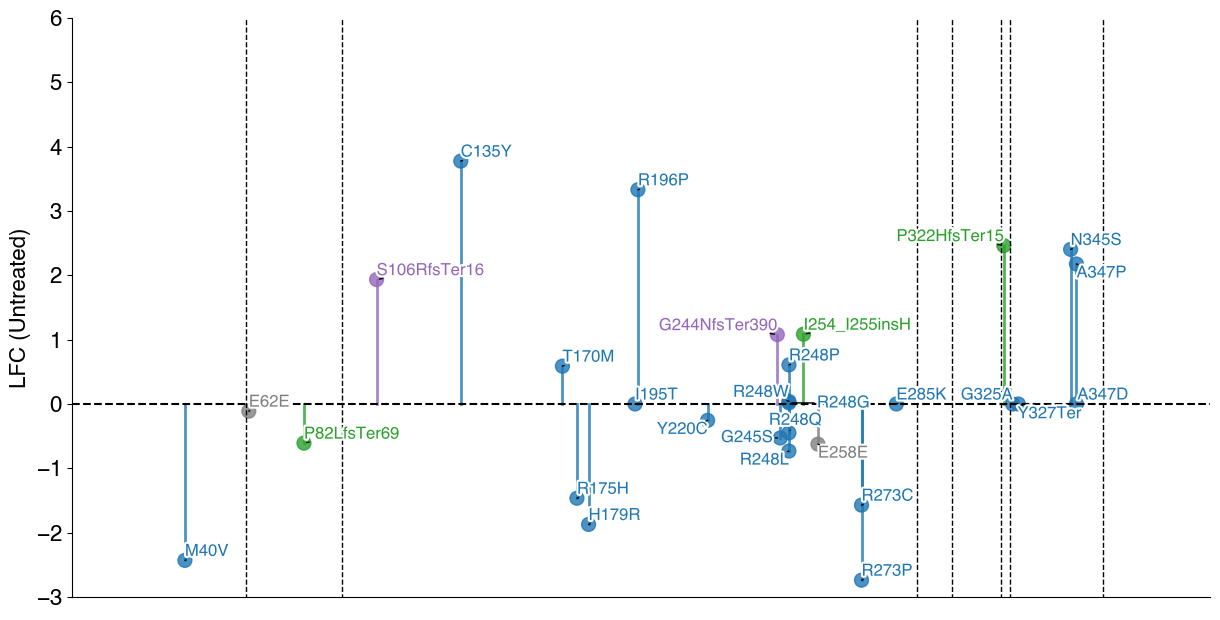

In [28]:
#and then plot

fig, ax = plt.subplots( figsize=(12,6))

lfc = comp['LFC_untreated']
lfc[np.isnan(lfc)]=0

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}
colors = [c_dict[i] for i in comp['Effect']]

for i, v in comp.iterrows():
    val = v['codon']
    ax.plot([val, val], [0, lfc[i]], color = colors[i], linewidth=2, alpha=.8)

ax.scatter(comp['codon'], lfc, color=colors, s=100, alpha=.8)

ax.set_xlim(1,393)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
ax.set_ylabel("LFC (Untreated)", fontsize=16)


boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


ax.plot([1,393], [0,0], linestyle='dashed', color='black')

t = list(comp['HGVSp'])
x=np.array(comp['codon'])
y = lfc#+np.random.uniform(0,.5, len(x))

texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=colors[i], path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

ax.set_ylim(-3,6)

#adjust_text(texts, ax=ax[0])
fig.tight_layout(pad=0)

adjust_text(texts,only_move={'points':'y', 'texts':'y'},arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'), ax=ax)

## Figure 5b

LFC of 29 pegRNAs selected for validation at Day 34 in the Nutlin-treated condition. Variants with insufficient control counts (I195T, E285K, G325A, Y327Ter, A347D) represented with LFC = 0.

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_21844/1007933200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc[np.isnan(lfc)]=0


5

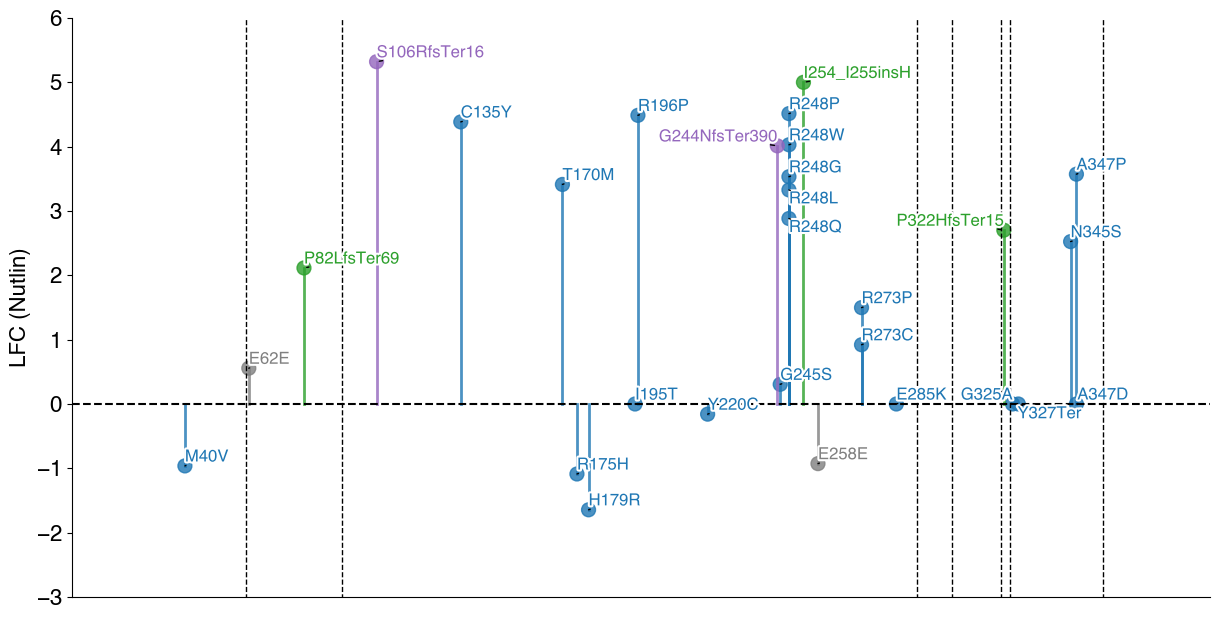

In [31]:
#and then plot

fig, ax = plt.subplots( figsize=(12,6))

lfc = comp['LFC_nutlin']
lfc[np.isnan(lfc)]=0

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}
colors = [c_dict[i] for i in comp['Effect']]

for i, v in comp.iterrows():
    val = v['codon']
    ax.plot([val, val], [0, lfc[i]], color = colors[i], linewidth=2, alpha=.8)

ax.scatter(comp['codon'], lfc, color=colors, s=100, alpha=.8)

ax.set_xlim(1,393)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
ax.set_ylabel("LFC (Nutlin)", fontsize=16)


boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


ax.plot([1,393], [0,0], linestyle='dashed', color='black')

t = list(comp['HGVSp'])
x=np.array(comp['codon'])
y = lfc#+np.random.uniform(0,.5, len(x))

texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=colors[i], path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

ax.set_ylim(-3,6)

#adjust_text(texts, ax=ax[0])
fig.tight_layout(pad=0)

adjust_text(texts,only_move={'points':'y', 'texts':'y'},arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'), ax=ax)

## Figure 5c

Visualization of correct editing percentages and number of patient occurrences (MSK-IMPACT) for the pegRNAs selected for validation.

In [29]:
high1 = comp[comp['Corr_perc_nutlin']>=30].index
low1 = comp[comp['Corr_perc_nutlin']<=9.4].index
med1 = comp[(comp['Corr_perc_nutlin']>9.4) & (comp['Corr_perc_nutlin']<30)].index

comp['efficiency'] = np.zeros(len(comp))
comp.loc[high1, 'efficiency'] = 'high'
comp.loc[med1, 'efficiency'] = 'medium'
comp.loc[low1, 'efficiency'] = 'low'

low = comp[comp['efficiency']=='low'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)
med = comp[comp['efficiency']=='medium'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)
high = comp[comp['efficiency']=='high'].reset_index().sort_values(by='Corr_perc_nutlin', ascending=False)

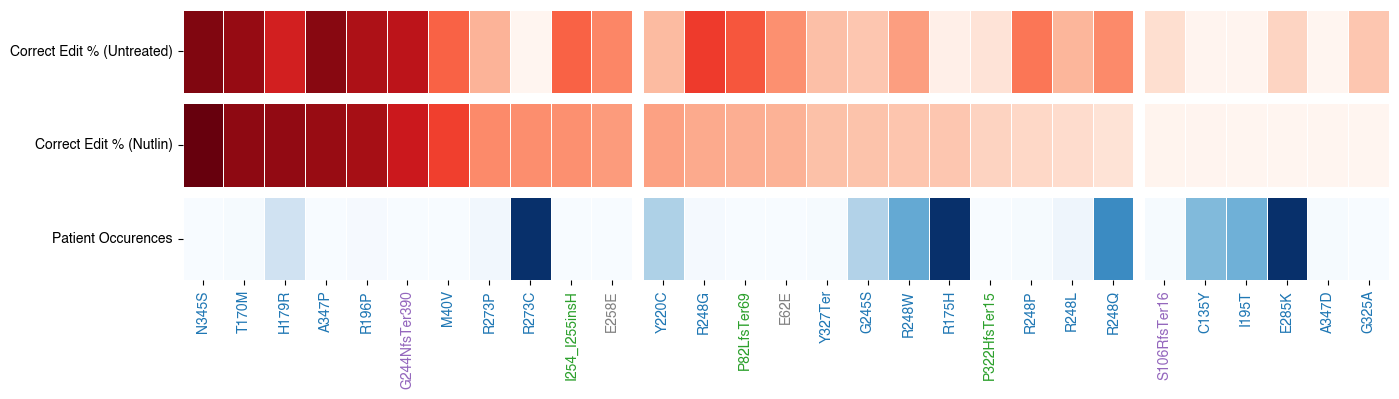

In [30]:
fig, ax = plt.subplots(3,3,figsize=(14,4), sharey=False, sharex=False, width_ratios=[11, 12, 6])
#high, medium, low

g = sns.heatmap([high['Corr_perc_untreated']], ax= ax[0][0], linewidth=.5, cmap='Reds', vmin=0, vmax=86, cbar=False)
g = sns.heatmap([high['Corr_perc_nutlin']], ax= ax[1][0], linewidth=.5,cmap='Reds', vmin=0, vmax=86, cbar=False)
g1 = sns.heatmap([high['num_occurences']], ax= ax[2][0], linewidth=.5,cmap='Blues', cbar=False)

g = sns.heatmap([med['Corr_perc_untreated']], ax= ax[0][1], linewidth=.5, cmap='Reds', vmin=0, vmax=86, cbar=False)
g = sns.heatmap([med['Corr_perc_nutlin']], ax= ax[1][1], linewidth=.5, cmap='Reds', vmin=0, vmax=86, cbar=False)
g2 = sns.heatmap([med['num_occurences']], ax= ax[2][1], linewidth=.5, cmap='Blues', cbar=False)

g = sns.heatmap([low['Corr_perc_untreated']], ax= ax[0][2], linewidth=.5,cmap='Reds', vmin=0, vmax=86, cbar=False)
g = sns.heatmap([low['Corr_perc_nutlin']], ax= ax[1][2], linewidth=.5,cmap='Reds', vmin=0, vmax=86, cbar=False)
g3 = sns.heatmap([low['num_occurences']], ax= ax[2][2], linewidth=.5,cmap='Blues', cbar=False)

#ax[0].set_yticklabels(['LFC Untreated'], rotation=0)
#ax[1].set_yticklabels(['LFC Nutlin'], rotation=0)
ax[0][0].set_yticklabels(['Correct Edit % (Untreated)'], rotation=0)
ax[1][0].set_yticklabels(['Correct Edit % (Nutlin)'], rotation=0)
ax[2][0].set_yticklabels(['Patient Occurences'], rotation=0)

ax[0][1].set_yticks([])
ax[1][1].set_yticks([])
ax[2][1].set_yticks([])
ax[0][2].set_yticks([])
ax[1][2].set_yticks([])
ax[2][2].set_yticks([])

ax[0][0].set_xticks([])
ax[1][0].set_xticks([])
ax[0][1].set_xticks([])
ax[1][1].set_xticks([])
ax[0][2].set_xticks([])
ax[1][2].set_xticks([])
#ax[4].set_xticklabels(comp['HGVSp'], rotation=90)

ax[2][0].set_xticklabels(high['HGVSp'], rotation=90)
ax[2][1].set_xticklabels(med['HGVSp'], rotation=90)
ax[2][2].set_xticklabels(low['HGVSp'], rotation=90)

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}

for i, tick_label in enumerate(g1.axes.get_xticklabels()):
    cc = c_dict[high.iloc[i]['Effect']]
    tick_label.set_color(cc)

for i, tick_label in enumerate(g2.axes.get_xticklabels()):
    cc = c_dict[med.iloc[i]['Effect']]
    tick_label.set_color(cc)

for i, tick_label in enumerate(g3.axes.get_xticklabels()):
    cc = c_dict[low.iloc[i]['Effect']]
    tick_label.set_color(cc)

fig.tight_layout(pad=.75)

## Figure 5d

Selected competition assays show the change in the RFP positive cell fraction in the presence or absence of various selection agents.

To take into account low event number (as a result of low numbers of viable cells), for replicates with fewer than 400 events, these are assumed to be unchanged from the previous time-point. This is done to prevent the drawing of conclusions from flow data with very low sample sizes.

Here, showing ALL competition assays (not just selected few shown in the original figure).

Orange = Nutlin; Blue = Untreated; Purple = COTI-2; Green = PK7088

In [68]:
merge_w_names = pd.read_csv('competition_assay_data/Competition_assay_data.csv')

#taking into account low event numbers
t1 = merge_w_names[merge_w_names['Events_t1']<=400].index
t2 = merge_w_names[merge_w_names['Events_t2']<=400].index

merge_w_names2 = merge_w_names.copy()

for i in t1:
    merge_w_names2.loc[i, "RFP_t1"] = merge_w_names2.iloc[i]['RFP_t0']

for i in t2:
    merge_w_names2.loc[i, "RFP_t2"] = merge_w_names2.iloc[i]['RFP_t1']

In [69]:
melted = merge_w_names2.melt(id_vars = ['Sample_Number', 'Replicate', 'Condition'])

melted = melted[melted['variable'].isin(['RFP_t0', 'RFP_t1', 'RFP_t2'])]
t_dict = {'RFP_t0':0, 'RFP_t1':7, 'RFP_t2':14}

melted['variable'] = [t_dict[i] for i in melted['variable']]
melted = melted.rename(columns = {'variable':'Time (Days)', 'value': 'RFP%'})


In [70]:
merge_w_names2

,Sample_Number,HGVSp,Condition,Replicate,Events_t0,RFP_t0,Events_t1,RFP_t1,Events_t2,RFP_t2
0,1,R175H,Nutlin,1,12238,8.74,664.0,10.50,433.0,7.85
1,1,R175H,Nutlin,2,12238,8.74,467.0,11.80,264.0,11.80
2,1,R175H,Nutlin,3,12238,8.74,416.0,8.89,215.0,8.89
3,1,R175H,Untreated,1,12238,8.74,11996.0,8.63,11349.0,5.99
4,1,R175H,Untreated,2,12238,8.74,10905.0,9.05,11544.0,6.40
...,...,...,...,...,...,...,...,...,...,...
175,29,E258E,Nutlin,2,10017,69.40,368.0,69.40,65.0,69.40
176,29,E258E,Nutlin,3,10017,69.40,395.0,69.40,90.0,69.40
177,29,E258E,Untreated,1,10017,69.40,10359.0,37.60,10668.0,5.53
178,29,E258E,Untreated,2,10017,69.40,10536.0,40.20,10750.0,16.90


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_21844/2112689114.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = melted[melted['Sample_Number']==sample_num], x='Time (Days)', y='RFP%', hue='Condition', hue_order = hue_order, palette = colors, ax = ax[row][col], legend=False)
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_21844/2112689114.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = melted[melted['Sample_Number']==sample_num], x='Time (Days)', y='RFP%', hue='Condition', hue_order = hue_order, palette = colors, ax = ax[row][col], legend=False)


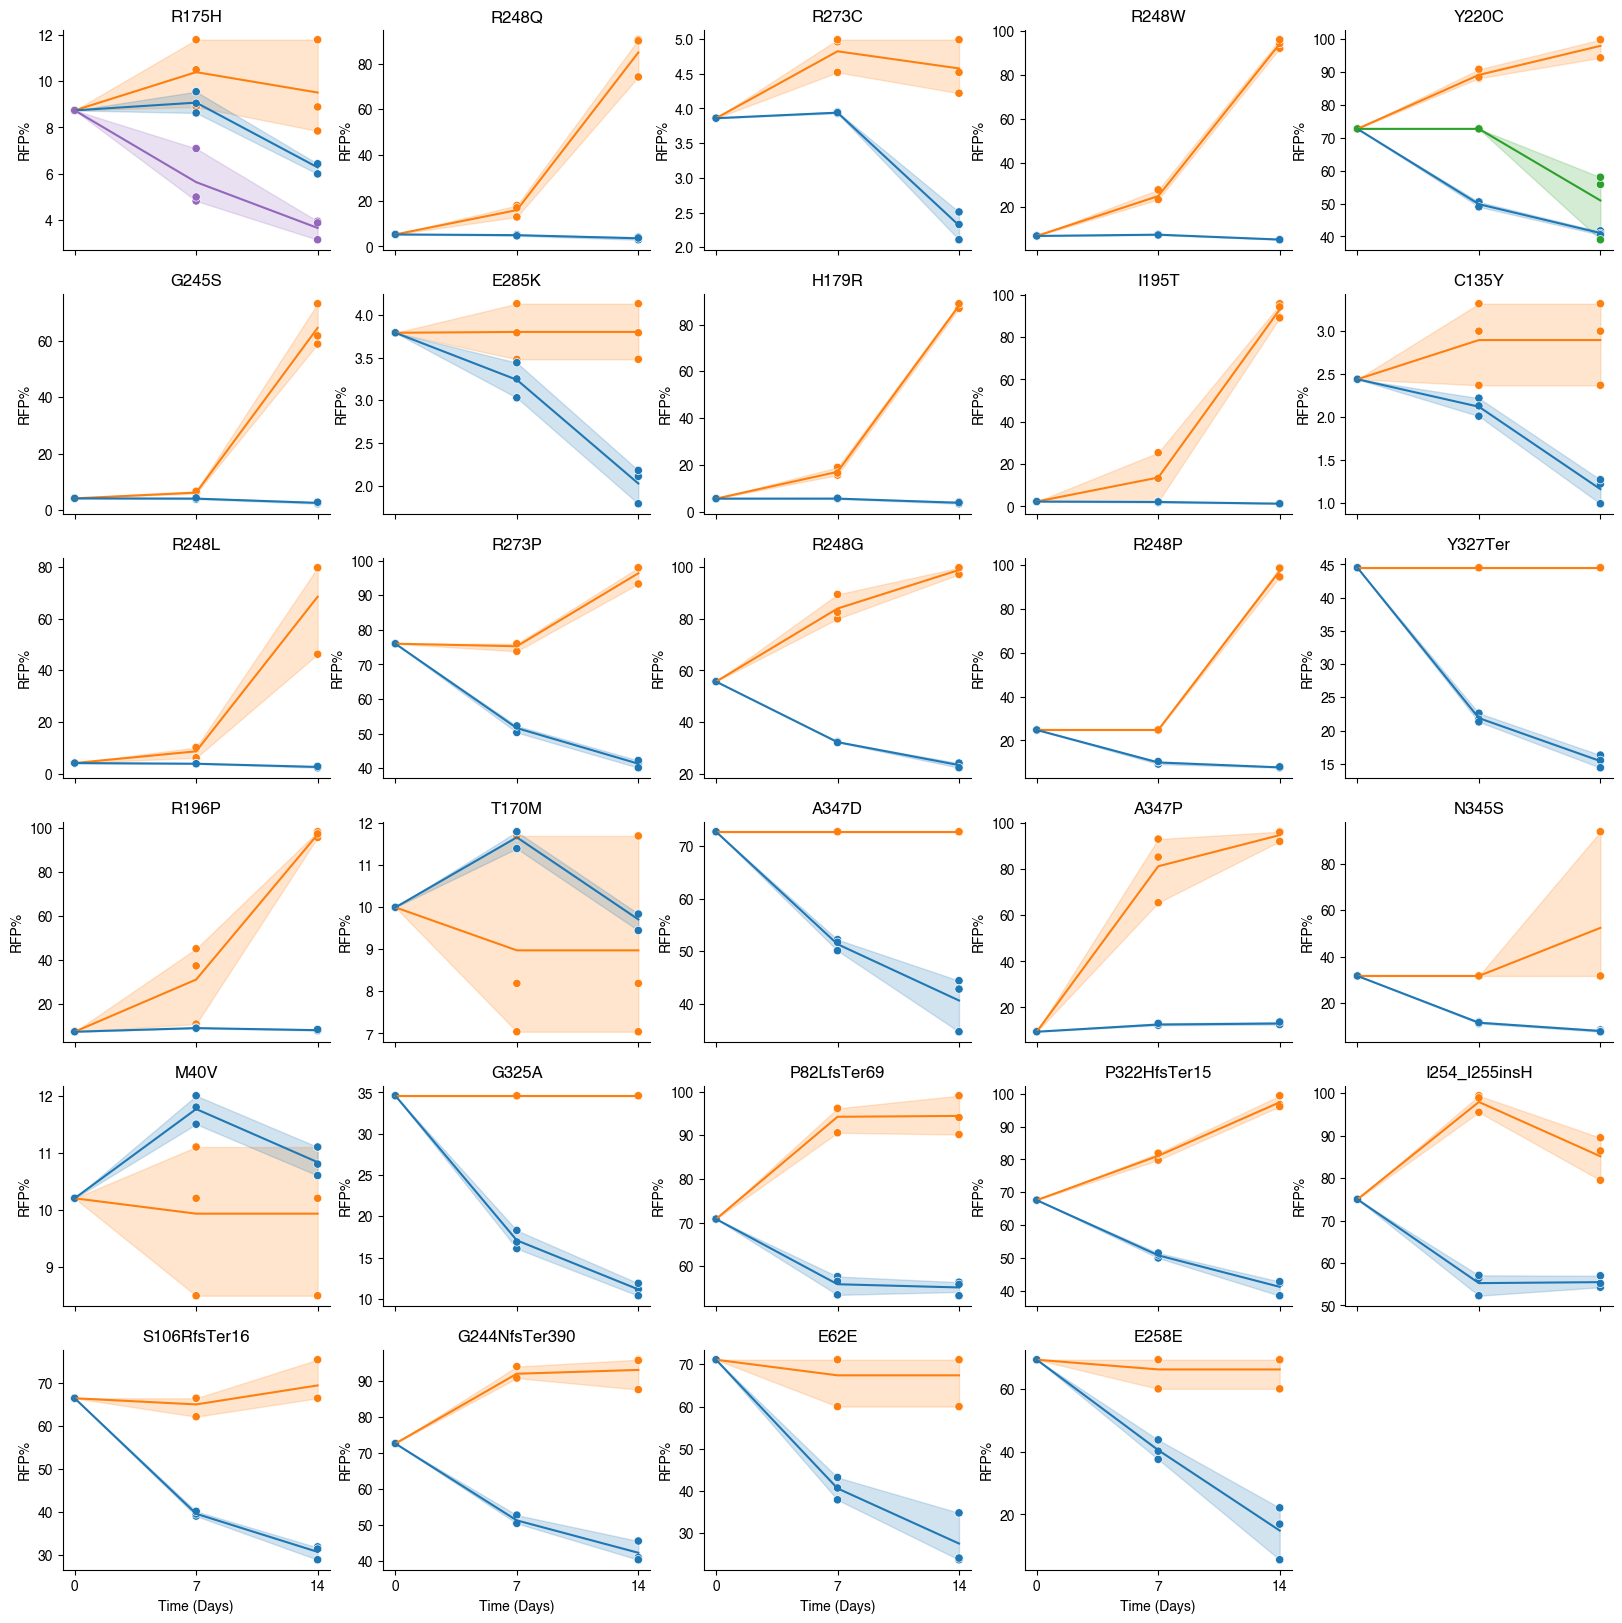

In [71]:
fig, ax = plt.subplots(6,5, figsize=(20,20), sharex=True, sharey=False)

hue_order = ['Nutlin', 'Untreated', 'COTI-2', 'PK7088']
colors = ['tab:orange', 'tab:blue', 'tab:purple', 'tab:green']
for i in range(6):
    for k in range(5):
        row = i%6
        col = k
        sample_num = k +1+ i*5 

        sns.lineplot(data = melted[melted['Sample_Number']==sample_num], x='Time (Days)', y='RFP%', hue='Condition', hue_order = hue_order, palette = colors, ax = ax[row][col], legend=False)
        sns.scatterplot(data = melted[melted['Sample_Number']==sample_num], x='Time (Days)', y='RFP%', hue='Condition', hue_order = hue_order, palette = colors, ax = ax[row][col], legend=False)
        if sample_num<=29:
            tit = merge_w_names2[merge_w_names2['Sample_Number']==sample_num]['HGVSp'].values[0]
            ax[row][col].set_title(tit)
            ax[row][col].spines['top'].set_visible(False)
            ax[row][col].spines['right'].set_visible(False)
            
        else:
            continue

ax[0][0].set_xticks([0,7,14])
fig.delaxes(ax[5][4])

## Figure 5e

The change in the RFP positive cell fraction (∆RFP+ %) at the initial versus final time-point for each variant in the presence or absence of Nutlin-3.

In [72]:
merge_w_names2['∆RFP+ %'] = merge_w_names2['RFP_t2'] - merge_w_names2['RFP_t0']

merge_w_names2 = pd.merge(merge_w_names2, comp, on='HGVSp')

melted2 = merge_w_names2.melt(id_vars = ['Sample_Number', 'Replicate', 'Condition', 'HGVSp', 'efficiency'])
melted2 = melted2[melted2['variable']=='∆RFP+ %']

,Sample_Number,Replicate,Condition,HGVSp,efficiency,variable,value
1080,1,1,Nutlin,R175H,medium,∆RFP+ %,-0.89
1081,1,2,Nutlin,R175H,medium,∆RFP+ %,3.06
1082,1,3,Nutlin,R175H,medium,∆RFP+ %,0.15
1083,1,1,Untreated,R175H,medium,∆RFP+ %,-2.75
1084,1,2,Untreated,R175H,medium,∆RFP+ %,-2.34
...,...,...,...,...,...,...,...
1255,29,2,Nutlin,E258E,high,∆RFP+ %,0.0
1256,29,3,Nutlin,E258E,high,∆RFP+ %,0.0
1257,29,1,Untreated,E258E,high,∆RFP+ %,-63.87
1258,29,2,Untreated,E258E,high,∆RFP+ %,-52.5


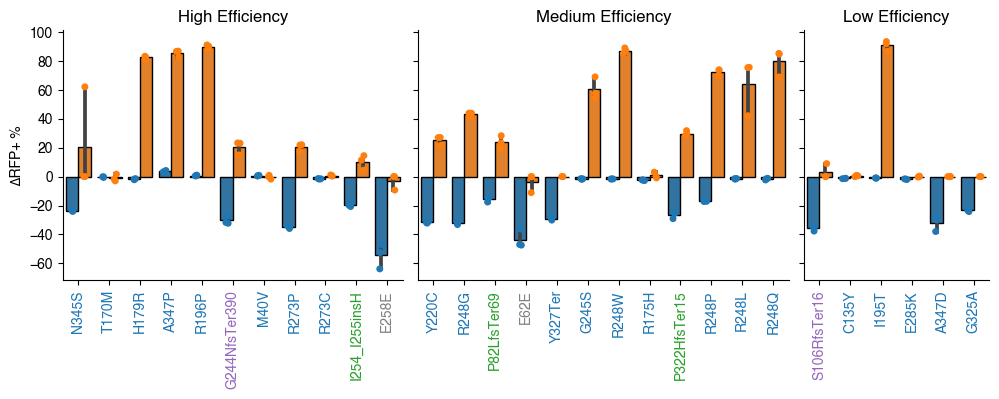

In [99]:
#and plotting
melted2 = melted2.rename(columns ={'value': '∆RFP+ %'})

fig, ax = plt.subplots(1,3, figsize=(10,4), width_ratios = [len(high1), len(med1), len(low1)], sharey=True)
hue_order=['Untreated','Nutlin']
g = sns.barplot(data = melted2[melted2['efficiency']=='high'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=high['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[0])
g = sns.stripplot(data = melted2[melted2['efficiency']=='high'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=high['HGVSp'], hue_order = hue_order, dodge=True, ax=ax[0])

g2 = sns.barplot(data = melted2[melted2['efficiency']=='medium'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=med['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[1])
g2 = sns.stripplot(data = melted2[melted2['efficiency']=='medium'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=med['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[1])

g3 = sns.barplot(data = melted2[melted2['efficiency']=='low'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=low['HGVSp'], linewidth=1, edgecolor='black', hue_order = hue_order, ax=ax[2])
g3 = sns.stripplot(data = melted2[melted2['efficiency']=='low'],x='HGVSp',y='∆RFP+ %' ,hue='Condition',order=low['HGVSp'], hue_order = hue_order, dodge=True,ax=ax[2])

#-----and making the plot pretty

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].legend_.remove()
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_title('High Efficiency')
ax[1].set_title('Medium Efficiency')
ax[2].set_title('Low Efficiency')
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)

c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'grey'}

for i, tick_label in enumerate(g.axes.get_xticklabels()):
    cc = c_dict[high.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(90)

for i, tick_label in enumerate(g2.axes.get_xticklabels()):
    cc = c_dict[med.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(90)

for i, tick_label in enumerate(g3.axes.get_xticklabels()):
    cc = c_dict[low.iloc[i]['Effect']]
    tick_label.set_color(cc)
    tick_label.set_rotation(90)

fig.tight_layout(pad=.75)



## Figure 5f
Venn diagram visualizing the agreement between enrichment in the presence of Nutlin in the competition assays (∆RFP+ % ≥ 5) and the original screen (LFC ≥ 1) for high and medium efficiency pegRNA validation sets. 


In [125]:
grouped = merge_w_names2[merge_w_names2['Condition']=='Nutlin'].groupby('HGVSp').median().reset_index()

grouped_high = grouped[grouped['HGVSp'].isin(high['HGVSp'])]
grouped_medium = grouped[grouped['HGVSp'].isin(med['HGVSp'])]

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_21844/474802037.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = merge_w_names2[merge_w_names2['Condition']=='Nutlin'].groupby('HGVSp').median().reset_index()


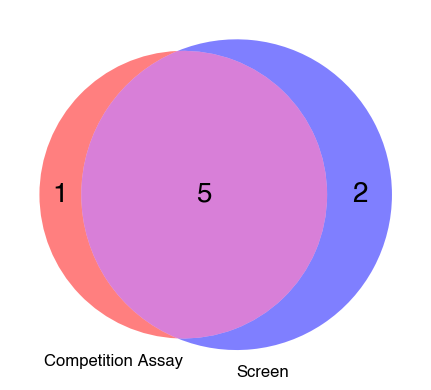

In [126]:
from matplotlib_venn import venn2

df = grouped_high

# Create tuple to store number of elements in each subset
subsets_data = (len(df[df['∆RFP+ %']>=5])-len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]), 
                len(df[df['LFC_nutlin']>=1])-len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]), 
                len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]))

v_test1 = venn2(subsets=subsets_data, set_labels = ('Competition Assay', 'Screen'), alpha = 0.5, set_colors=("red", "blue"))

for t in v_test1.subset_labels: t.set_fontsize(20)


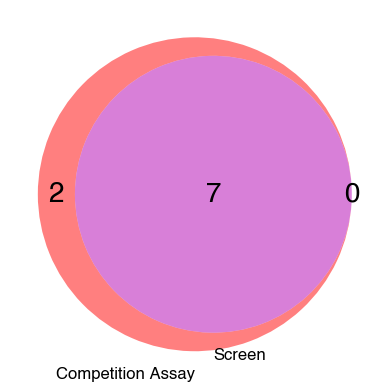

In [127]:
df = grouped_medium

# Create tuple to store number of elements in each subset
subsets_data = (len(df[df['∆RFP+ %']>=1])-len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]), 
                len(df[df['LFC_nutlin']>=1])-len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]), 
                len(df[(df['∆RFP+ %']>=5) & (df['LFC_nutlin']>=1)]))

v_test1 = venn2(subsets=subsets_data, set_labels = ('Competition Assay', 'Screen'), alpha = 0.5, set_colors=("red", "blue"))

for t in v_test1.subset_labels: t.set_fontsize(20)